# HOUMIL: High Utility Occupancy Pattern Mining with Indexed List.
This notebook implements the HOUMIL algorithm for for Mining High Utility Occupancy Patterns Based on Indexed List Structure

In [1]:
import os
import time
import random
import tracemalloc
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple, Set
import heapq
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

In [2]:
# QuadrupleEntry Class
class QuadrupleEntry:
    """
    Data structure for storing transaction item relationships in HUOMIL.
    
    PURPOSE:
    Represents a single entry in an indexed list, linking items within a 
    transaction through index pointers instead of transaction IDs.
    
    ATTRIBUTES:
    next_item : str or None
        The next item that appears after this item in the transaction.
        None if this is the last item.
    
    uo : float
        Utility Occupancy - the ratio of this item's utility to total 
        transaction utility (u(i,T) / TU(T)).
        Range: [0.0, 1.0]
    
    ruo : float
        Remaining Utility Occupancy - sum of utility occupancies for all 
        items that appear AFTER this item in the transaction.
        Range: [0.0, 1.0]
    
    next_idx : int or None
        Index pointer to the next_item's entry in its GUO-IL.
        Enables O(1) access without TID comparison (key innovation).
        None if next_item is None.
    
    EXAMPLE:
    Transaction T1: {(A, qty=2), (B, qty=3), (C, qty=1)}
    External utilities: {A: 5, B: 2, C: 3}
    
    Transaction Utility (TU): (2×5) + (3×2) + (1×3) = 19
    
    Processing in REVERSE order (C → B → A):
    
    Entry for C:
        QuadrupleEntry(
            next_item=None,      # C is last item
            uo=3/19=0.158,       # u(C,T1) / TU(T1)
            ruo=0.0,             # No items after C
            next_idx=None        # No next item
        )
    
    Entry for B:
        QuadrupleEntry(
            next_item='C',       # C comes after B
            uo=6/19=0.316,       # u(B,T1) / TU(T1)
            ruo=0.158,           # uo(C) = 0.158
            next_idx=0           # Pointer to C's entry at index 0
        )
    
    Entry for A:
        QuadrupleEntry(
            next_item='B',       # B comes after A
            uo=10/19=0.526,      # u(A,T1) / TU(T1)
            ruo=0.474,           # uo(B) + uo(C) = 0.316 + 0.158
            next_idx=0           # Pointer to B's entry at index 0
        )
    """
    __slots__ = ['next_item', 'uo', 'ruo', 'next_idx']
    
    def __init__(self, next_item, uo, ruo, next_idx):
        """
        Initialize a QuadrupleEntry.
        
        Parameters
        next_item : str or None
            Next item in transaction sequence
        uo : float
            Utility occupancy value [0.0, 1.0]
        ruo : float
            Remaining utility occupancy [0.0, 1.0]
        next_idx : int or None
            Index pointer to next item's entry
        """
        self.next_item = next_item
        self.uo = uo
        self.ruo = ruo
        self.next_idx = next_idx

print("QuadrupleEntry class loaded (memory-optimized with __slots__)")

QuadrupleEntry class loaded (memory-optimized with __slots__)


In [3]:
# IndexedList Class
class IndexedList:
    """
    GUO-IL (Global Utility Occupancy Indexed List) or CUO-IL (Conditional Utility Occupancy Indexed List)
    
    PURPOSE:
    Core data structure in HUOMIL for storing all QuadrupleEntry objects for a specific 
    item or itemset (pattern). Enables efficient traversal, pruning, and pattern extension.
    
    KEY FEATURES:
    - Stores QuadrupleEntry objects indexed by pattern (single item or tuple itemset)
    - Maintains aggregated sum_uo and sum_ruo for fast pruning decisions
    - Supports O(1) access to next-item relationships via next_idx pointers
    - Memory-optimized using __slots__ to eliminate per-instance __dict__
    
    ATTRIBUTES:
    pattern : tuple of str
        The itemset this IndexedList represents. Always stored as tuple for consistency.
        Single items are converted to 1-tuples during initialization.
    
    entries : list[QuadrupleEntry]
        List of QuadrupleEntry objects for transactions containing this pattern.
        Each entry links to the next item in its original transaction.
    
    sum_uo : float
        Pre-computed sum of uo values across all entries. Used for pruning checks.
    
    sum_ruo : float  
        Pre-computed sum of ruo values across all entries. Used for pruning checks.
    
    USAGE EXAMPLE:
    il_A = IndexedList('A')  # Represents pattern {A}
    il_A.add_entry(QuadrupleEntry(next_item='B', uo=0.526, ruo=0.474, next_idx=0))
    il_A.get_support()  # Returns 1
    il_A.get_uo()       # Returns 0.526
    
    il_AB = IndexedList(('A', 'B'))  # Represents pattern {A,B}
    """
    __slots__ = ['pattern', 'entries', 'sum_uo', 'sum_ruo']
    
    def __init__(self, pattern):
        """
        Initialize an IndexedList for a given pattern.
        
        Parameters:
        pattern : str or tuple
            Single item (str) or itemset (tuple of str) this list represents
        """
        self.pattern = pattern if isinstance(pattern, tuple) else tuple([pattern])
        self.entries = []  # List of QuadrupleEntry
        self.sum_uo = 0.0  # Sum of utility occupancy (aggregated info)
        self.sum_ruo = 0.0  # Sum of remaining utility occupancy
    
    def add_entry(self, entry: QuadrupleEntry):
        """
        Add QuadrupleEntry and update aggregated sums for pruning.
        
        Parameters:
        entry : QuadrupleEntry
            Entry to append to this IndexedList
        """
        """Add entry and update aggregated information"""
        self.entries.append(entry)
        self.sum_uo += entry.uo
        self.sum_ruo += entry.ruo
    
    def get_support(self):
        """
        Return support count (number of transactions containing this pattern).
        
        Returns:
        int: Number of QuadrupleEntry objects (== transaction support)
        """
        """Return support (number of entries)"""
        return len(self.entries)
    
    def get_uo(self):
        """
        Calculate average utility occupancy across all entries.
        
        Returns:
        float: Average uo value, or 0.0 if empty
        """
        """Calculate utility occupancy"""
        if len(self.entries) == 0:
            return 0.0
        return self.sum_uo / len(self.entries)


print("IndexedList class loaded!")

IndexedList class loaded!


In [4]:
# HUOMIL Algorithm Class
class HUOMIL:
    """
    HUOMIL: High Utility Occupancy Pattern Mining with Indexed List Structure
    
    REFERENCE:
    Kim et al. (2023) - IEEE Access
    "Efficient Method for Mining High Utility Occupancy Patterns Based on Indexed List Structure"
    
    PURPOSE:
    Complete implementation of the HUOMIL algorithm for mining high utility occupancy (HUO) patterns.
    Dramatically faster than traditional utility mining by replacing TID-lists with IndexedLists
    containing QuadrupleEntry index pointers (Lemma 2: O(1) next-item access).
    
    IMPLEMENTS:
    - Algorithm 1: HUOMIL main procedure (Lines 1-13)
    - Algorithm 2: ConstructGUOIL procedure (Lines 1-19) 
    - Algorithm 3: Search procedure (Lines 1-32)
    
    CORE INNOVATIONS:
    1. GUO-IL/CUO-IL structures replace expensive TID-list intersections
    2. Reverse transaction scanning builds O(1) index pointers (Algorithm 2)
    3. Two-level pruning: LUBUO (loose) + UBUO (tight) upper bounds
    4. Direct chain following for pattern extension (no TID comparison)
    
    
    USAGE EXAMPLE:
    huomil = HUOMIL(min_sup_ratio=0.001, min_uo_ratio=0.2)
    results = huomil.fit(transactions_dict, profit_table)
    # results: [(('A','B'), 150, 0.25), (('B','C'), 120, 0.18), ...]
    """
    
    def __init__(self, min_sup_ratio: float, min_uo_ratio: float):
        """
        Initialize HUOMIL with minimum thresholds.
        
        PARAMETERS:
        min_sup_ratio : float [0.0, 1.0]
            Minimum support ratio (α). Absolute min_sup = ceil(|D| × α)
        min_uo_ratio : float [0.0, 1.0]  
            Minimum utility occupancy ratio (β). Pattern uo(X) ≥ β
            
        INTERNAL STATE:
        - min_sup: Absolute minimum support (calculated from |D|)
        - transactions_dict: Input database {TID: [(item, qty), ...]}
        - external_utilities: {item: profit_per_unit}
        - guo_ils: {item: IndexedList} global indexed lists
        """
        """Initialize HUOMIL"""
        
        self.min_sup_ratio = min_sup_ratio
        self.min_uo_ratio = min_uo_ratio
        
        # Will be set during fit()
        self.min_sup = 0
        self.transactions_dict = None
        self.external_utilities = None
        
        # Results
        self.result_patterns = []
        
        # Item support for first scan
        self.item_support = defaultdict(int)
        
        # Total order (support-ascending)
        self.total_order = []
        self.item_to_idx = {}
        
        # Global indexed lists
        self.guo_ils = {}
    
    def calculate_utility(self, item: str, quantity: int) -> float:
        """
        Calculate internal utility of item in transaction.
        
        FORMULA:
        u(i,T) = quantity(i,T) × external_utility(i)
        
        PARAMETERS:
        item : str
            Item identifier
        quantity : int
            Quantity in transaction
            
        RETURNS:
        float: Item utility (0.0 if item not in external_utilities)
        """
        """Calculate utility: quantity × external_utility"""
        return quantity * self.external_utilities.get(item, 0)
    
    def calculate_transaction_utility(self, transaction: List[Tuple[str, int]]) -> float:
        """
        Calculate total utility of transaction.
        
        FORMULA:
        TU(T) = Σ_{i∈T} u(i,T)
        
        PARAMETERS:
        transaction : List[Tuple[str,int]]
            List of (item, quantity) tuples
            
        RETURNS:
        float: Total transaction utility
        """
        """Calculate total utility of transaction"""
        total = 0.0
        for item, quantity in transaction:
            total += self.calculate_utility(item, quantity)
        return total
    
    def first_database_scan(self):
        """
        Algorithm 1, Lines 1-10: First scan to calculate item support and total order.
        
        STEPS:
        1. Count support for each item across all transactions
        2. Filter items: support ≥ min_sup  
        3. Sort promising items by support (ascending) → total_order (Def. 7)
        
        MODIFIES:
        - self.item_support: {item: support_count}
        - self.total_order: List[str] sorted by support
        - self.item_to_idx: {item: position_in_total_order}
        """
        """
        Algorithm 1, Lines 1-10: First scan to calculate support
        """
        print("  [1/3] First database scan: calculating item support...")
        
        for tid, transaction in self.transactions_dict.items():
            for item, _ in transaction:
                self.item_support[item] += 1
        
        # Filter items by minimum support and create total order
        promising_items = [(item, sup) for item, sup in self.item_support.items() 
                          if sup >= self.min_sup]
        
        # Sort by support (ascending order) - Definition 7 from paper
        promising_items.sort(key=lambda x: x[1])
        self.total_order = [item for item, _ in promising_items]
        self.item_to_idx = {item: idx for idx, item in enumerate(self.total_order)}
        
        print(f"      Found {len(self.total_order)} promising items (min_sup={self.min_sup})")
    
    def construct_guo_ils(self):
        """
        Algorithm 2: ConstructGUOIL procedure (Lines 1-19).
        
        KEY INNOVATION:
        Process transactions in REVERSE order to build index pointers.
        Enables O(1) traversal of connected items without TID comparison.
        
        FOR EACH TRANSACTION T (Lines 3-17):
        1. Calculate TU(T)
        2. Revise T by total_order (only promising items)
        3. Process items from LAST→FIRST:
           - uo(i,T) = u(i,T) / TU(T)
           - ruo accumulates from tail
           - Store next_idx pointer to enable chain following
        """
        """Algorithm 2: Construct Global Utility Occupancy Indexed Lists"""
        print("  [2/3] Second database scan: constructing GUO-ILs...")
        
        for tid, transaction in self.transactions_dict.items():
            # Calculate transaction utility
            tu = self.calculate_transaction_utility(transaction)
            if tu == 0:
                continue
            
            # Filter and sort transaction by total order
            revised_trans = [(item, qty) for item, qty in transaction 
                        if item in self.item_to_idx]
            revised_trans.sort(key=lambda x: self.item_to_idx[x[0]])
            
            # Process transaction in REVERSE order (Algorithm 2, Lines 6-17)
            ruo = 0.0
            next_item = None
            next_idx = None
            
            for i in range(len(revised_trans) - 1, -1, -1):
                item, quantity = revised_trans[i]
                
                # Calculate utility occupancy (Line 11)
                u_item = self.calculate_utility(item, quantity)
                uo = u_item / tu
                
                # Create or get GUO-IL for this item
                if item not in self.guo_ils:
                    self.guo_ils[item] = IndexedList(item)
                
                # Create quadruple entry (Line 12)
                entry = QuadrupleEntry(next_item, uo, ruo, next_idx)
                self.guo_ils[item].add_entry(entry)
                
                # Update for next iteration (Lines 13-15)
                ruo = ruo + uo  # Accumulate remaining utility occupancy
                next_item = item
                next_idx = len(self.guo_ils[item].entries) - 1
        
        print(f"      Constructed {len(self.guo_ils)} GUO-ILs")
    
    def calculate_lubuo(self, indexed_list: IndexedList) -> float:
        """
        Calculate Loose Upper-Bound Utility Occupancy (Pruning Strategy 1).
        
        FORMULA (Def. 11, Eq. 12):
        LUBUO(X) = (∑uo(X) + ∑ruo(X)) / minsup
        
        PURPOSE:
        Quick conservative upper bound. If LUBUO(X) < β, no extensions possible.
        """
        """Calculate loose upper bound utility occupancy"""
        if self.min_sup == 0:
            return 0.0
        return (indexed_list.sum_uo + indexed_list.sum_ruo) / self.min_sup
    
    def calculate_ubuo(self, indexed_list: IndexedList) -> float:
        """
        Calculate Tight Upper-Bound Utility Occupancy (Pruning Strategy 2).
        
        FORMULA (Def. 9, Eq. 11):
        UBUO(X) = Σ(top_K(uo(e) + ruo(e) for e∈entries(X))) / minsup
        where K = minsup
        
        PURPOSE:
        More precise bound using top-K largest (uo+ruo) values.
        """
        """Calculate upper bound utility occupancy"""
        if self.min_sup == 0:
            return 0.0
        
        # Collect uo + ruo for each entry
        values = [entry.uo + entry.ruo for entry in indexed_list.entries]
        
        # Get top min_sup values
        if len(values) < self.min_sup:
            top_values = values
        else:
            top_values = heapq.nlargest(self.min_sup, values)
        
        return sum(top_values) / self.min_sup
    
    def mine_patterns(self, prefix: tuple, cuo_set: Dict[str, IndexedList], 
                     base_list: IndexedList = None) -> List[Tuple[tuple, float, int]]:
        """
        Algorithm 3: Search procedure - recursive DFS pattern mining.
        
        PRUNING STRATEGIES (Lines 3-9):
        1. support(P) < minsup → discard
        2. uo(P) ≥ β → output HUO-pattern  
        3. LUBUO(P) < β → pruning
        4. UBUO(P) < β → pruning
        
        PATTERN EXTENSION (Lines 10-25):
        Use create_cuo_ils() to build next-level conditional lists via index chains.
        """
        """Algorithm 3: Recursively mine patterns using DFS"""
        results = []
        
        # Process each pattern in current level (Algorithm 3, Line 2)
        for item, cuo_il in cuo_set.items():
            current_pattern = prefix + (item,)
            support = cuo_il.get_support()
            
            # Check minimum support constraint (Line 3)
            if support < self.min_sup:
                continue
            
            # Calculate utility occupancy (Lines 4-6)
            uo_value = cuo_il.get_uo()
            
            # Check if it's a high utility occupancy pattern
            if uo_value >= self.min_uo_ratio:
                results.append((current_pattern, uo_value, support))
            
            # Pruning Strategy 1: Check loose upper bound (Line 7)
            lubuo = self.calculate_lubuo(cuo_il)
            if lubuo < self.min_uo_ratio:
                continue
            
            # Pruning Strategy 2: Check tight upper bound (Lines 8-9)
            ubuo = self.calculate_ubuo(cuo_il)
            if ubuo < self.min_uo_ratio:
                continue
            
            # Extend pattern (Lines 10-25)
            # Create CUO-ILs for next level by following index chains
            next_cuo_set = self.create_cuo_ils(cuo_il, base_list)
            
            if len(next_cuo_set) > 0:
                # Recursive mining (Lines 28-29)
                # Pass current cuo_il as base_list for next level
                results.extend(self.mine_patterns(current_pattern, next_cuo_set, cuo_il))
        
        return results
    
    def create_cuo_ils(self, prefix_il: IndexedList, 
                      base_list: IndexedList = None) -> Dict[str, IndexedList]:
        """
        Algorithm 3, Lines 11-24: Create conditional IndexedLists for pattern extension.
        
        KEY INNOVATION (Lemma 2):
        Follow index chains (next_item → next_idx) directly from QuadrupleEntry.
        NO TID-list intersection required - O(1) per connection.
        
        UTILITY OCCUPANCY CALCULATION (Lines 18-20):
        new_uo = prefix_uo + connected_uo - base_uo
        Prevents double-counting prefix utility for k≥3 patterns.
        """
        """Create conditional indexed lists for pattern extension"""
        cuo_set = {}
        
        # Create new base list for this prefix (Line 12)
        new_base_list = IndexedList(prefix_il.pattern)
        
        for entry_idx, entry in enumerate(prefix_il.entries):
            # Store prefix utility occupancy in base list
            base_entry = QuadrupleEntry(None, entry.uo, 0, None)
            new_base_list.add_entry(base_entry)
            
            # Follow the chain of connected entries (Line 13)
            next_item = entry.next_item
            next_idx = entry.next_idx
            
            # Key innovation: Direct pointer following (no TID comparison)
            while next_item is not None and next_item in self.guo_ils:
                # Get the connected entry from GUO-IL (Lines 14-16)
                target_guo = self.guo_ils[next_item]
                
                if next_idx >= len(target_guo.entries):
                    break
                    
                connected_entry = target_guo.entries[next_idx]
                
                # Create or get CUO-IL for extended pattern
                if next_item not in cuo_set:
                    cuo_set[next_item] = IndexedList(next_item)
                
                # Calculate utility occupancy (Lines 18-20)
                # Line 18: Find the entry pe of Base-list in CUO_k
                if base_list is not None and entry_idx < len(base_list.entries):
                    prefix_uo = base_list.entries[entry_idx].uo
                else:
                    prefix_uo = 0.0
                
                # Line 19: ne.uo ← e.uo + ce.uo 
                # This prevents double-counting for k >= 3 itemsets
                new_uo = entry.uo + connected_entry.uo
                new_ruo = connected_entry.ruo  # Line 20
                
                # Create new entry (Line 17)
                new_entry = QuadrupleEntry(
                    connected_entry.next_item,
                    new_uo,
                    new_ruo,
                    connected_entry.next_idx
                )
                cuo_set[next_item].add_entry(new_entry)
                
                # Move to next in chain (Line 22)
                next_item = connected_entry.next_item
                next_idx = connected_entry.next_idx
        
        return cuo_set
    
    def fit(self, transactions_dict: Dict[str, List[Tuple[str, int]]], 
            profit_table: Dict[str, float]) -> List[Tuple[tuple, int, float]]:
        """
        Execute complete HUOMIL algorithm (Algorithm 1 wrapper).
        
        INPUT FORMAT:
        transactions_dict : Dict[str, List[Tuple[str,int]]]
            {TID: [(item1, qty1), (item2, qty2), ...]}
        profit_table : Dict[str, float]
            {item: profit_per_unit}
            
        RETURNS:
        List[Tuple[tuple, int, float]]:
            [(pattern_tuple, support_count, utility_occupancy), ...]
            All patterns where support ≥ α|D| AND uo ≥ β
        """
        """Main execution method (Algorithm 1)"""
        print(f"\nStarting HUOMIL Algorithm (Alpha={self.min_sup_ratio}, Beta={self.min_uo_ratio})...")
        
        # Store data
        self.transactions_dict = transactions_dict
        self.external_utilities = profit_table
        self.min_sup = max(1, int(len(transactions_dict) * self.min_sup_ratio))
        
        # Reset state
        self.result_patterns = []
        self.item_support.clear()
        self.guo_ils.clear()
        
        # Algorithm 1: Main HUOMIL
        self.first_database_scan()
        
        # Algorithm 2: Construct GUO-ILs
        self.construct_guo_ils()
        
        # Algorithm 3: Mine patterns
        print("  [3/3] Mining patterns...")
        
        # Convert GUO-ILs to initial dictionary for mining
        initial_cuo_set = {item: guo_il for item, guo_il in self.guo_ils.items()}
        
        # Start recursive mining with empty prefix
        self.result_patterns = self.mine_patterns(tuple(), initial_cuo_set)
        
        print(f"      Found {len(self.result_patterns)} patterns")
        
        # Convert to format matching (pattern, support, uo)
        formatted_results = [
            (pattern, support, uo) 
            for pattern, uo, support in self.result_patterns
        ]
        
        return formatted_results


print("HUOMIL class loaded successfully!")

HUOMIL class loaded successfully!


## Helper Functions
Functions for data loading, profit table generation

In [5]:
def parse_dataset(filepath: str) -> Tuple[List[List[str]], Set[str]]:
    """
    Parse space-delimited transactional dataset file into item-only transactions.
    
    PURPOSE:
    Read standard sparse transaction format (one transaction per line, 
    space-separated item IDs) used by most utility mining algorithms.
    
    INPUT FORMAT:
    ```
    A B C
    B D
    A C
    ```
    
    OUTPUT FORMAT:
    ```
    transactions: [['A','B','C'], ['B','D'], ['A','C']]
    all_items: {'A','B','C','D'}
    ```
    
    ERROR HANDLING:
    - FileNotFoundError → empty lists/sets with error message
    - Malformed lines (empty after strip) → skipped silently
    - Other IO errors → empty lists/sets with error message
    
    PARAMETERS:
    filepath : str
        Path to dataset file
        
    RETURNS:
    Tuple[List[List[str]], Set[str]]:
        - transactions: List of transaction lists (items as strings)
        - all_items: Set of all unique items across dataset
    """
    """Parse a space-delimited transactional dataset file."""
    transactions = []
    all_items = set()
    
    print(f"Parsing dataset: {filepath}")
    
    try:
        with open(filepath, 'r') as f:
            for line_num, line in enumerate(f, 1):
                items = line.strip().split()
                if items:
                    transactions.append(items)
                    all_items.update(items)
        
        print(f"  Parsed {len(transactions)} transactions, {len(all_items)} unique items.")
        
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return [], set()
    except Exception as e:
        print(f"Error reading file: {e}")
        return [], set()
    
    return transactions, all_items



def generate_profit_table(all_items: Set[str], 
                          min_profit: float = 0.1,
                          max_profit: float = 10.0) -> Dict[str, float]:
    """
    Generate synthetic external utility (profit) table for utility mining.
    
    PURPOSE:
    Assign random profit-per-unit values to items for experimentation.
    Simulates real-world scenario where items have different profit margins.
    
    DISTRIBUTION:
    Uniform random [min_profit, max_profit], rounded to 2 decimal places.
    
    EXAMPLE:
    Input: {'A','B','C'}
    Output: {'A': 3.45, 'B': 7.82, 'C': 1.23}
    
    PARAMETERS:
    all_items : Set[str]
        All unique items requiring profit values
    min_profit : float = 0.1
        Minimum profit per unit
    max_profit : float = 10.0  
        Maximum profit per unit
        
    RETURNS:
    Dict[str, float]: {item → profit_per_unit}
    """
    """Generate a dictionary assigning random profit values to each item."""
    print(f"Generating profit table for {len(all_items)} items...")
    
    profit_table = {}
    sorted_items = sorted(list(all_items))
    for item in sorted_items:
        profit_table[item] = round(random.uniform(min_profit, max_profit), 2)
    
    return profit_table



def simulate_quantitative_data(
    base_transactions: List[List[str]],
    min_quantity: int = 1,
    max_quantity: int = 5
) -> Tuple[Dict[str, List[Tuple[str, int]]], Dict[str, float]]:
    """
    Convert sparse transactions to quantitative format for HUOMIL.
    
    PURPOSE:
    Transform item-only transactions into HUOMIL-compatible format by:
    1. Assigning TID strings (T1, T2, ...)
    2. Adding random quantities per item [min_quantity, max_quantity]
    3. Generating matching profit table
    
    INPUT FORMAT:
    [['A','B'], ['B','C','D']]
    
    OUTPUT FORMAT:
    transactions_dict: {
        'T1': [('A', 3), ('B', 1)], 
        'T2': [('B', 4), ('C', 2), ('D', 5)]
    }
    profit_table: {'A': 5.2, 'B': 3.1, ...}
    
    PARAMETERS:
    base_transactions : List[List[str]]
        Sparse transactions (items only)
    min_quantity : int = 1
        Minimum quantity per item occurrence
    max_quantity : int = 5
        Maximum quantity per item occurrence
        
    RETURNS:
    Tuple[Dict[str, List[Tuple[str,int]]], Dict[str,float]]:
        - transactions_dict: {TID → [(item, quantity), ...]}
        - profit_table: {item → profit_per_unit}
    """
    """Simulate quantitative transaction data by assigning random quantities to items."""
    all_items = set()
    for tx in base_transactions:
        all_items.update(tx)
    
    profit_table = generate_profit_table(all_items)
    
    print(f"Simulating quantitative data for {len(base_transactions)} transactions...")
    
    transactions_dict = {}
    for i, tx in enumerate(base_transactions):
        tid = f"T{i+1}"
        quantitative_tx = []
        
        for item in tx:
            quantity = random.randint(min_quantity, max_quantity)
            quantitative_tx.append((item, quantity))
        
        transactions_dict[tid] = quantitative_tx
    
    return transactions_dict, profit_table


print("Dataset parsing functions loaded!")

Dataset parsing functions loaded!


## Experiment: Running HUOMIL Miner
Below, data is loaded, parameters set, mining is executed, and results are saved.

In [6]:
BASE_OUTPUT_DIR = "huomil_results"
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)


def run_dataset_experiment(dataset_name, filepath, alpha_tests, beta_tests):
    """
    Execute complete HUOMIL parameter sweep experiment for one dataset.
    
    PURPOSE:
    Comprehensive benchmarking function that:
    1. Parses sparse dataset → quantitative transactions + profit table
    2. Runs full grid search over α×β parameter combinations  
    3. Measures runtime/memory/pattern count for each run
    4. Saves individual pattern files (.txt)
    5. Compiles summary statistics (CSV + display)
    
    OUTPUT STRUCTURE:
    ```
    huomil_results/
    └── Retail/
        ├── Retail_a0.001_b0.2.txt     # Individual patterns
        ├── Retail_a0.001_b0.3.txt
        └── Retail_summary.csv         # All experiment metrics
    ```
    
    SUMMARY CSV COLUMNS:
    | dataset | alpha | beta | runtime_sec | peak_memory_mb | patterns_found | pattern_file_path |
    
    ERROR HANDLING:
    - Dataset loading failure → skip dataset with error message
    - Individual mining failure → skip that (α,β) combo, continue others
    
    PARAMETERS:
    dataset_name : str
        Name for output folder (e.g., "Retail", "Mushroom")
    filepath : str  
        Path to space-delimited transaction file
    alpha_tests : List[float]
        Minimum support ratios to test [0.001, 0.002, ...]
    beta_tests : List[float] 
        Minimum UO ratios to test [0.2, 0.3, ...]
        
    RETURNS:
    None (saves files, prints progress, displays summary DataFrame)
    """
    """Runs HUOMIL experiments for a specific dataset and saves results into a dedicated subfolder."""
    print(f"START RUNNING: {dataset_name}")
    
    # 1. Create Sub-directory: huomil_results/Retail/
    dataset_dir = os.path.join(BASE_OUTPUT_DIR, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)
    print(f"Output Directory: {dataset_dir}")

    # 2. Parse & Simulate Data
    try:
        print(f"Loading data from: {filepath}")
        random.seed(42)
        base_transactions, all_items = parse_dataset(filepath)
        print(f"Parsed {len(base_transactions)} transactions.")
        
        print("Generating synthetic utility values...")
        transactions_dict, profit_table = simulate_quantitative_data(base_transactions)
        
    except Exception as e:
        print(f"CRITICAL ERROR loading {dataset_name}: {e}")
        return

    summary_list = []

    # 3. Main Loop
    for alpha in alpha_tests:
        for beta in beta_tests:
            print(f"\nRunning: Alpha={alpha}, Beta={beta} ...")
            
            miner = HUOMIL(min_sup_ratio=alpha, min_uo_ratio=beta)
            
            tracemalloc.start()
            start_time = time.time()
            
            try:
                # EXECUTE
                huops_results = miner.fit(transactions_dict, profit_table)
                
                # METRICS
                end_time = time.time()
                current_mem, peak_mem = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                runtime = end_time - start_time
                peak_memory_mb = peak_mem / (1024 * 1024)
                num_patterns = len(huops_results)
                
                print(f"DONE in {runtime:.4f}s | Mem: {peak_memory_mb:.2f}MB | Patterns: {num_patterns}")

                # 4. Save Pattern File
                pattern_filename = f"{dataset_name}_a{alpha}_b{beta}.txt"
                pattern_path = os.path.join(dataset_dir, pattern_filename)
                
                with open(pattern_path, "w") as f:
                    f.write(f"# Dataset: {dataset_name}\n")
                    f.write(f"# Params: Alpha={alpha}, Beta={beta}\n")
                    f.write(f"# Runtime: {runtime:.6f}s\n")
                    f.write(f"# Peak Memory: {peak_memory_mb:.6f} MB\n")
                    f.write(f"# Count: {num_patterns}\n")
                    for pat in huops_results:
                        f.write(f"{pat}\n")
                
                # Add to summary
                summary_list.append({
                    'dataset': dataset_name,
                    'algorithm': 'HUOMIL',
                    'alpha': alpha,
                    'beta': beta,
                    'runtime_sec': runtime,
                    'peak_memory_mb': peak_memory_mb,
                    'patterns_found': num_patterns,
                    'pattern_file_path': pattern_path
                })

            except Exception as e:
                print(f"ERROR during mining: {e}")
                tracemalloc.stop()

    # 5. Save Dataset Summary CSV
    if summary_list:
        df_final = pd.DataFrame(summary_list)
        csv_path = os.path.join(dataset_dir, f"{dataset_name}_summary.csv")
        df_final.to_csv(csv_path, index=False)
        print(f"\n{dataset_name} Experiment Finished. Summary saved to: {csv_path}")
        display(df_final)
    else:
        print(f"\n{dataset_name} Experiment Finished. No results to save.")


print("Experiment runner function loaded!")
print("\nReady to run experiments with run_dataset_experiment()")

Experiment runner function loaded!

Ready to run experiments with run_dataset_experiment()


In [10]:
##Sample Testing with Small Data

In [7]:
# Small test with toy data
print("SMALL TEST: Verifying HUOMIL implementation")

toy_transactions = {
    'T1': [('A', 2), ('B', 6), ('C', 1)],
    'T2': [('A', 1), ('D', 3), ('G', 2)],
    'T3': [('B', 1), ('D', 2), ('G', 3)],
    'T4': [('A', 1), ('C', 5), ('D', 2)],
    'T5': [('B', 4), ('D', 1), ('F', 1)],
}

toy_profits = {
    'A': 3.0, 'B': 1.0, 'C': 1.0,
    'D': 5.0, 'F': 3.0, 'G': 2.0,
}

miner = HUOMIL(min_sup_ratio=0.4, min_uo_ratio=0.3)
results = miner.fit(toy_transactions, toy_profits)

print("\nResults:")
for pattern, support, uo in results[:10]:
    print(f"  {pattern}: sup={support}, uo={uo:.4f}")

print("\nSmall test completed successfully!")

SMALL TEST: Verifying HUOMIL implementation

Starting HUOMIL Algorithm (Alpha=0.4, Beta=0.3)...
  [1/3] First database scan: calculating item support...
      Found 5 promising items (min_sup=2)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 5 GUO-ILs
  [3/3] Mining patterns...
      Found 5 patterns

Results:
  ('B', 'D'): sup=2, uo=0.6985
  ('A', 'D'): sup=2, uo=0.7702
  ('C', 'A'): sup=2, uo=0.4915
  ('D',): sup=4, uo=0.5606
  ('G', 'D'): sup=2, uo=0.9024

Small test completed successfully!


### --- RETAIL EXPERIMENT ---

In [8]:
dataset_name = "Retail"
filepath = "datasets/retail.txt" 

alphas = [0.002,0.001,0.0008] 
betas = [0.2,0.3]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Retail
Output Directory: huomil_results/Retail
Loading data from: datasets/retail.txt
Parsing dataset: datasets/retail.txt
  Parsed 88162 transactions, 16470 unique items.
Parsed 88162 transactions.
Generating synthetic utility values...
Generating profit table for 16470 items...
Simulating quantitative data for 88162 transactions...

Running: Alpha=0.002, Beta=0.2 ...

Starting HUOMIL Algorithm (Alpha=0.002, Beta=0.2)...
  [1/3] First database scan: calculating item support...
      Found 963 promising items (min_sup=176)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 963 GUO-ILs
  [3/3] Mining patterns...
      Found 299 patterns
DONE in 16.7928s | Mem: 73.18MB | Patterns: 299

Running: Alpha=0.002, Beta=0.3 ...

Starting HUOMIL Algorithm (Alpha=0.002, Beta=0.3)...
  [1/3] First database scan: calculating item support...
      Found 963 promising items (min_sup=176)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 963 GUO

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Retail,HUOMIL,0.0020,0.2,16.792833,73.179679,299,huomil_results/Retail/Retail_a0.002_b0.2.txt
1,Retail,HUOMIL,0.0020,0.3,15.443716,73.126639,43,huomil_results/Retail/Retail_a0.002_b0.3.txt
2,Retail,HUOMIL,0.0010,0.2,27.927460,89.936403,751,huomil_results/Retail/Retail_a0.001_b0.2.txt
3,Retail,HUOMIL,0.0010,0.3,25.452815,89.884997,111,huomil_results/Retail/Retail_a0.001_b0.3.txt
4,Retail,HUOMIL,0.0008,0.2,31.532450,95.178183,1031,huomil_results/Retail/Retail_a0.0008_b0.2.txt
5,Retail,HUOMIL,0.0008,0.3,30.244611,95.169621,143,huomil_results/Retail/Retail_a0.0008_b0.3.txt


### --- Foodmart EXPERIMENT ---

In [9]:
dataset_name = "Foodmart"
filepath = "datasets/foodmartFIM.txt" 

alphas = [0.005,0.001,0.0005]
betas = [0.2, 0.3]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Foodmart
Output Directory: huomil_results/Foodmart
Loading data from: datasets/foodmartFIM.txt
Parsing dataset: datasets/foodmartFIM.txt
  Parsed 4141 transactions, 1559 unique items.
Parsed 4141 transactions.
Generating synthetic utility values...
Generating profit table for 1559 items...
Simulating quantitative data for 4141 transactions...

Running: Alpha=0.005, Beta=0.2 ...

Starting HUOMIL Algorithm (Alpha=0.005, Beta=0.2)...
  [1/3] First database scan: calculating item support...
      Found 20 promising items (min_sup=20)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 20 GUO-ILs
  [3/3] Mining patterns...
      Found 12 patterns
DONE in 0.0556s | Mem: 0.10MB | Patterns: 12

Running: Alpha=0.005, Beta=0.3 ...

Starting HUOMIL Algorithm (Alpha=0.005, Beta=0.3)...
  [1/3] First database scan: calculating item support...
      Found 20 promising items (min_sup=20)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 20 GUO-

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Foodmart,HUOMIL,0.0050,0.2,0.055614,0.099189,12,huomil_results/Foodmart/Foodmart_a0.005_b0.2.txt
1,Foodmart,HUOMIL,0.0050,0.3,0.024502,0.094581,9,huomil_results/Foodmart/Foodmart_a0.005_b0.3.txt
2,Foodmart,HUOMIL,0.0010,0.2,0.413256,2.743574,933,huomil_results/Foodmart/Foodmart_a0.001_b0.2.txt
3,Foodmart,HUOMIL,0.0010,0.3,0.315013,2.669123,399,huomil_results/Foodmart/Foodmart_a0.001_b0.3.txt
4,Foodmart,HUOMIL,0.0005,0.2,0.375548,3.064565,3302,huomil_results/Foodmart/Foodmart_a0.0005_b0.2.txt
5,Foodmart,HUOMIL,0.0005,0.3,0.386395,2.918088,2280,huomil_results/Foodmart/Foodmart_a0.0005_b0.3.txt


### --- Mushroom EXPERIMENT ---

In [10]:
# # Mushroom dataset (dense)
dataset_name = "Mushroom"
filepath = "datasets/mushrooms.txt"
alphas = [0.4,0.3,0.2] 
betas = [0.4,0.5]   
run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Mushroom
Output Directory: huomil_results/Mushroom
Loading data from: datasets/mushrooms.txt
Parsing dataset: datasets/mushrooms.txt
  Parsed 8416 transactions, 119 unique items.
Parsed 8416 transactions.
Generating synthetic utility values...
Generating profit table for 119 items...
Simulating quantitative data for 8416 transactions...

Running: Alpha=0.4, Beta=0.4 ...

Starting HUOMIL Algorithm (Alpha=0.4, Beta=0.4)...
  [1/3] First database scan: calculating item support...
      Found 21 promising items (min_sup=3366)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 21 GUO-ILs
  [3/3] Mining patterns...
      Found 0 patterns
DONE in 3.1713s | Mem: 24.22MB | Patterns: 0

Running: Alpha=0.4, Beta=0.5 ...

Starting HUOMIL Algorithm (Alpha=0.4, Beta=0.5)...
  [1/3] First database scan: calculating item support...
      Found 21 promising items (min_sup=3366)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 21 GUO-ILs
  [3/3]

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Mushroom,HUOMIL,0.4,0.4,3.171322,24.219197,0,huomil_results/Mushroom/Mushroom_a0.4_b0.4.txt
1,Mushroom,HUOMIL,0.4,0.5,1.739510,24.214178,0,huomil_results/Mushroom/Mushroom_a0.4_b0.5.txt
2,Mushroom,HUOMIL,0.3,0.4,7.637867,31.081493,2,huomil_results/Mushroom/Mushroom_a0.3_b0.4.txt
3,Mushroom,HUOMIL,0.3,0.5,3.972873,27.926211,0,huomil_results/Mushroom/Mushroom_a0.3_b0.5.txt
4,Mushroom,HUOMIL,0.2,0.4,403.002428,44.228240,13147,huomil_results/Mushroom/Mushroom_a0.2_b0.4.txt
5,Mushroom,HUOMIL,0.2,0.5,154.529530,42.915045,2608,huomil_results/Mushroom/Mushroom_a0.2_b0.5.txt


### --- ChainStore EXPERIMENT ---

In [ ]:
# # Chainstore dataset
dataset_name = "Chainstore"
filepath = "datasets/chainstore.txt"
alphas = [0.01] 
betas = [0.2]
run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Chainstore
Output Directory: huomil_results/Chainstore
Loading data from: datasets/chainstore.txt
Parsing dataset: datasets/chainstore.txt
  Parsed 1112949 transactions, 910126 unique items.
Parsed 1112949 transactions.
Generating synthetic utility values...
Generating profit table for 910126 items...
Simulating quantitative data for 1112949 transactions...

Running: Alpha=0.01, Beta=0.2 ...

Starting HUOMIL Algorithm (Alpha=0.01, Beta=0.2)...
  [1/3] First database scan: calculating item support...
      Found 130 promising items (min_sup=11129)
  [2/3] Second database scan: constructing GUO-ILs...
      Constructed 130 GUO-ILs
  [3/3] Mining patterns...


Loading: huomil_results/Foodmart/Foodmart_summary.csv
Loading: huomil_results/Mushroom/Mushroom_summary.csv
Loading: huomil_results/Retail/Retail_summary.csv

Data loaded successfully. Columns: ['dataset', 'algorithm', 'alpha', 'beta', 'runtime_sec', 'peak_memory_mb', 'patterns_found', 'pattern_file_path']
Plotting details for: Foodmart
Saved to huomil_plots/Foodmart_analysis.png
Plotting details for: Mushroom


/var/folders/_2/v81jjchn4yg2gns8gfgr19rc0000gn/T/ipykernel_28286/2751222915.py:74: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].set_yscale('log') # Log scale is usually needed for patterns


Saved to huomil_plots/Mushroom_analysis.png
Plotting details for: Retail
Saved to huomil_plots/Retail_analysis.png
Plotting global comparison...


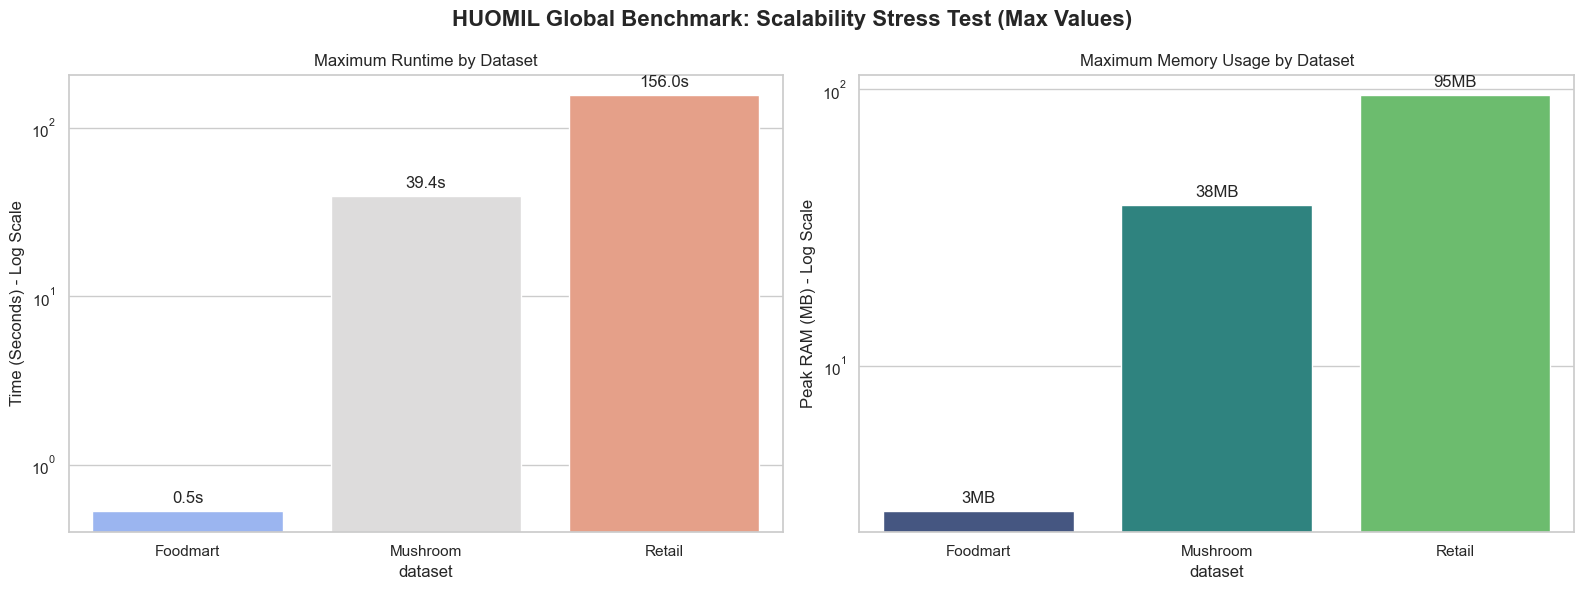

Saved to huomil_plots/Global_Comparison.png

All plots generated in folder: 'huomil_plots'


In [ ]:
# Configuration
RESULTS_DIR = "huomil_results"  
PLOTS_DIR = "huomil_plots"      
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set global style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

def load_all_summaries(root_dir):
    """
    Recursively finds all *_summary.csv files and combines them.
    """
    all_files = glob.glob(os.path.join(root_dir, "**", "*_summary.csv"), recursive=True)
    
    if not all_files:
        print("No summary CSV files found!")
        return pd.DataFrame()
    
    df_list = []
    for filename in all_files:
        print(f"Loading: {filename}")
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    return pd.DataFrame()

def plot_dataset_details(df, dataset_name):
    """
    Generates detailed line charts for a single dataset:
    1. Runtime vs Alpha
    2. Memory vs Alpha
    3. Patterns vs Alpha
    """
    print(f"Plotting details for: {dataset_name}")
    
    # Filter data for this dataset
    data = df[df['dataset'] == dataset_name].copy()
    
    # Sort to make line plots look right
    data = data.sort_values(by='alpha', ascending=False)
    
    # Create a 1x3 subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Dataset Analysis: {dataset_name}', fontsize=16, weight='bold')
    
    # Plot 1: Runtime
    sns.lineplot(ax=axes[0], data=data, x='alpha', y='runtime_sec', hue='beta', 
                 palette='viridis', marker='o', style='beta')
    axes[0].set_title('Runtime vs. Support (Alpha)')
    axes[0].set_ylabel('Time (Seconds)')
    axes[0].set_xlabel('Minimum Support (Alpha)')
    axes[0].invert_xaxis() # Standard convention: Lower support (harder) on right
    
    # Plot 2: Memory
    sns.lineplot(ax=axes[1], data=data, x='alpha', y='peak_memory_mb', hue='beta', 
                 palette='magma', marker='s', style='beta')
    axes[1].set_title('Memory Usage vs. Support')
    axes[1].set_ylabel('Peak RAM (MB)')
    axes[1].set_xlabel('Minimum Support (Alpha)')
    axes[1].invert_xaxis()
    
    # Plot 3: Patterns Found
    sns.lineplot(ax=axes[2], data=data, x='alpha', y='patterns_found', hue='beta', 
                 palette='deep', marker='^', style='beta')
    axes[2].set_title('Pattern Count vs. Support')
    axes[2].set_ylabel('Number of HUOPs')
    axes[2].set_xlabel('Minimum Support (Alpha)')
    axes[2].set_yscale('log') # Log scale is usually needed for patterns
    axes[2].invert_xaxis()
    
    # Save
    save_path = os.path.join(PLOTS_DIR, f"{dataset_name}_analysis.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved to {save_path}")

def plot_global_comparison(df):
    """
    Plots a high-level bar chart comparing all datasets.
    Since Alphas differ, we compare the Maximum Runtime/Memory recorded per dataset.
    """
    print("Plotting global comparison...")
    
    # Aggregate to find MAX impact per dataset (Stress Test view)
    df_agg = df.groupby('dataset').agg({
        'runtime_sec': 'max',
        'peak_memory_mb': 'max',
        'patterns_found': 'max'
    }).reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('HUOMIL Global Benchmark: Scalability Stress Test (Max Values)', fontsize=16, weight='bold')
    
    # Plot 1: Max Runtime Comparison
    # Removed 'legend=False' to prevent AttributeError on older seaborn versions
    sns.barplot(ax=axes[0], data=df_agg, x='dataset', y='runtime_sec', palette='coolwarm', hue='dataset', dodge=False)
    axes[0].set_title('Maximum Runtime by Dataset')
    axes[0].set_ylabel('Time (Seconds) - Log Scale')
    axes[0].set_yscale('log') # Crucial for Chainstore vs Foodmart
    
    # Manually remove legend if it exists (Compatible with all versions)
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()
    
    # Add labels on top
    for p in axes[0].patches:
        # Check if height is valid (not NaN or 0 for log scale safety)
        height = p.get_height()
        if height > 0:
            axes[0].annotate(f'{height:.1f}s', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    # Plot 2: Max Memory Comparison
    sns.barplot(ax=axes[1], data=df_agg, x='dataset', y='peak_memory_mb', palette='viridis', hue='dataset', dodge=False)
    axes[1].set_title('Maximum Memory Usage by Dataset')
    axes[1].set_ylabel('Peak RAM (MB) - Log Scale')
    axes[1].set_yscale('log')
    
    # Manually remove legend
    if axes[1].get_legend() is not None:
        axes[1].get_legend().remove()
    
    # Add labels on top
    for p in axes[1].patches:
        height = p.get_height()
        if height > 0:
            axes[1].annotate(f'{height:.0f}MB', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    save_path = os.path.join(PLOTS_DIR, "Global_Comparison.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved to {save_path}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Load Data
    full_df = load_all_summaries(RESULTS_DIR)
    
    if not full_df.empty:
        print("\nData loaded successfully. Columns:", full_df.columns.tolist())
        
        # 2. Plot Individual Dataset Details
        unique_datasets = full_df['dataset'].unique()
        for ds in unique_datasets:
            plot_dataset_details(full_df, ds)
            
        # 3. Plot Global Comparison
        plot_global_comparison(full_df)
        
        print(f"\nAll plots generated in folder: '{PLOTS_DIR}'")
    else:
        print("No data found to plot.")